In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121


In [2]:
# Path to dataset
dataset_path = r"C:\Users\DELL\Desktop\Fourth Year\Semester1\Deep Learning\weather"

# Parameters
img_size = (224, 224)
batch_size = 32

# Load the dataset and apply normalization
normalization_layer = layers.Rescaling(1.0 / 255)

# Load full dataset
full_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

# Split the dataset (70% train, 15% validation, 15% test)
data_size = len(full_dataset)
train_size = int(0.7 * data_size)
val_size = int(0.15 * data_size)
test_size = data_size - train_size - val_size

train_dataset = full_dataset.take(train_size)
remaining_dataset = full_dataset.skip(train_size)
validation_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)

# Apply normalization
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))


Found 6862 files belonging to 11 classes.


In [3]:
# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

# Apply augmentation to the training dataset
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

# Prefetch datasets for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [4]:
# Load DenseNet121 pre-trained on ImageNet
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
predictions = layers.Dense(len(full_dataset.class_names), activation="softmax")(x)

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers for initial transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [5]:
# Initial training (with frozen base layers)
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    steps_per_epoch=len(train_dataset),
    validation_steps=len(validation_dataset)
)

Epoch 1/10


150/150 [==============================] - 353s 2s/step - loss: 0.9414 - accuracy: 0.6833 - val_loss: 0.5793 - val_accuracy: 0.7988
Epoch 2/10
150/150 [==============================] - 223s 1s/step - loss: 0.5884 - accuracy: 0.8000 - val_loss: 0.5318 - val_accuracy: 0.8115
Epoch 3/10
150/150 [==============================] - 226s 2s/step - loss: 0.4946 - accuracy: 0.8252 - val_loss: 0.4899 - val_accuracy: 0.8164
Epoch 4/10
150/150 [==============================] - 227s 2s/step - loss: 0.4825 - accuracy: 0.8298 - val_loss: 0.5197 - val_accuracy: 0.8223
Epoch 5/10
150/150 [==============================] - 231s 2s/step - loss: 0.4606 - accuracy: 0.8373 - val_loss: 0.5144 - val_accuracy: 0.8242
Epoch 6/10
150/150 [==============================] - 226s 2s/step - loss: 0.4239 - accuracy: 0.8542 - val_loss: 0.4678 - val_accuracy: 0.8369
Epoch 7/10
150/150 [==============================] - 229s 2s/step - loss: 0.3991 - accuracy: 0.8569 - val_loss: 0.4736 - val_accuracy: 0.83

In [6]:
# Unfreeze deeper layers for fine-tuning
for layer in base_model.layers[-50:]:  # Unfreeze last 50 layers
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])

# Fine-tune the model
history_finetune = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=5,  # Fine-tuning for fewer epochs
    steps_per_epoch=len(train_dataset),
    validation_steps=len(validation_dataset)
)

Epoch 1/5
150/150 [==============================] - 249s 2s/step - loss: 0.5274 - accuracy: 0.8179 - val_loss: 0.5616 - val_accuracy: 0.8203
Epoch 2/5
150/150 [==============================] - 244s 2s/step - loss: 0.4030 - accuracy: 0.8592 - val_loss: 0.5732 - val_accuracy: 0.8164
Epoch 3/5
150/150 [==============================] - 243s 2s/step - loss: 0.3916 - accuracy: 0.8658 - val_loss: 0.5186 - val_accuracy: 0.8389
Epoch 4/5
150/150 [==============================] - 241s 2s/step - loss: 0.3748 - accuracy: 0.8656 - val_loss: 0.5321 - val_accuracy: 0.8340
Epoch 5/5
150/150 [==============================] - 237s 2s/step - loss: 0.3583 - accuracy: 0.8692 - val_loss: 0.5617 - val_accuracy: 0.8145


In [7]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

33/33 [==============================] - 44s 1s/step - loss: 0.5287 - accuracy: 0.8333
Test Accuracy: 83.33%


In [8]:
# Concatenate datasets for evaluation
def concatenate_datasets(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch)
        labels.append(label_batch)
    return tf.concat(images, axis=0), tf.concat(labels, axis=0)

test_images, test_labels = concatenate_datasets(test_dataset)

# Get model predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report
print("\nClassification Report:\n")
print(classification_report(test_labels, predicted_classes, target_names=full_dataset.class_names))


33/33 [==============================] - 36s 1s/step

Classification Report:

              precision    recall  f1-score   support

         dew       0.94      0.98      0.96        89
     fogsmog       0.75      0.94      0.83       126
       frost       0.69      0.78      0.73        76
       glaze       0.64      0.74      0.69        78
        hail       0.93      0.93      0.93       106
   lightning       0.94      1.00      0.97        66
        rain       0.79      0.84      0.81        75
     rainbow       0.91      0.97      0.94        30
        rime       0.88      0.83      0.85       187
   sandstorm       0.97      0.65      0.78       106
        snow       0.80      0.62      0.70        99

    accuracy                           0.83      1038
   macro avg       0.84      0.84      0.84      1038
weighted avg       0.84      0.83      0.83      1038



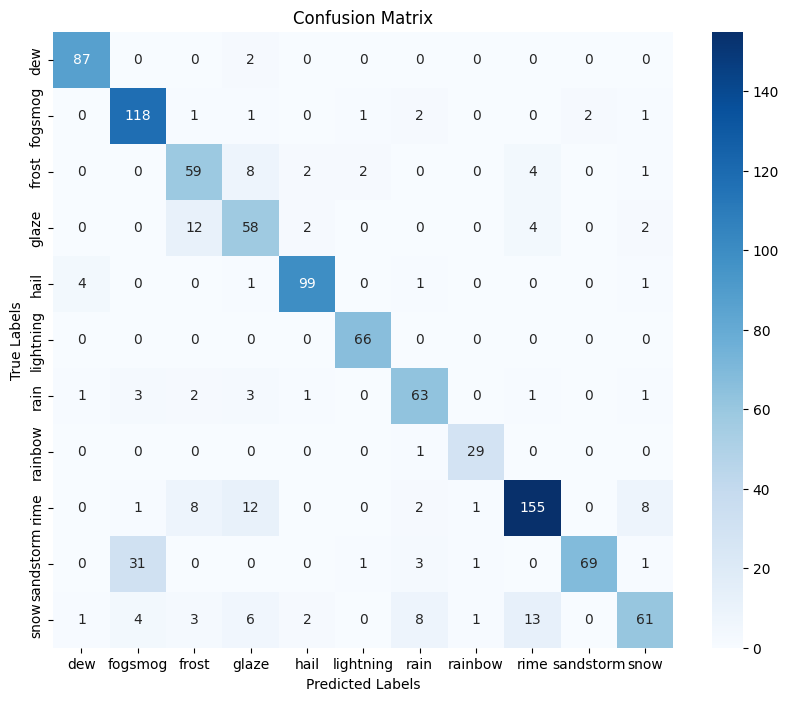

In [9]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.class_names, yticklabels=full_dataset.class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

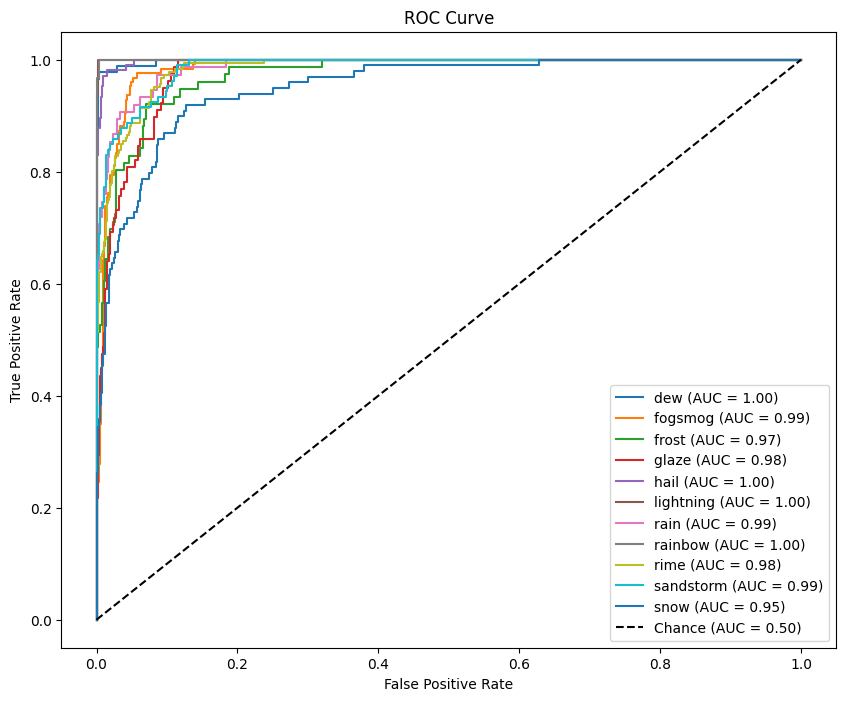

In [10]:
# Binarize true labels
true_classes_binarized = label_binarize(test_labels, classes=np.arange(len(full_dataset.class_names)))

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(full_dataset.class_names):
    fpr, tpr, _ = roc_curve(true_classes_binarized[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Add chance line
plt.plot([0, 1], [0, 1], "k--", label="Chance (AUC = 0.50)")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

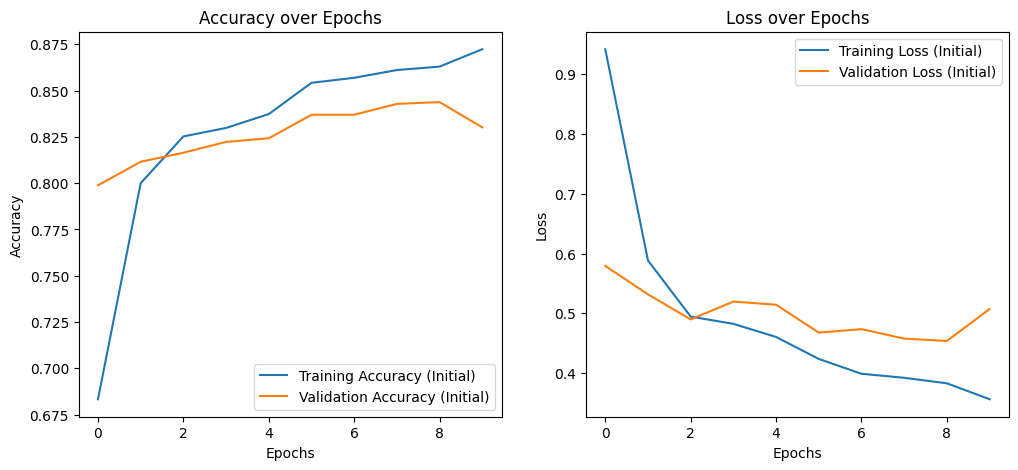

In [11]:
#Training History Visualization
def plot_history(history, history_finetune):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy (Initial)')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Initial)')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss (Initial)')
    plt.plot(history.history['val_loss'], label='Validation Loss (Initial)')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot training history
plot_history(history, history_finetune)